# IST 664 Final Project - SPAM Classification
## Date: March 24, 2020
## Author:
* Thomas Bahng
## Public GitHub repository
* [https://github.com/tbahng/ist664-NLP-and-Classification](https://github.com/tbahng/ist664-NLP-and-Classification)

# Introduction
SPAM filtering is a commonplace task for most email applications. For the user it saves time and clutter, and mitigates the risk of harm. SPAM emails may contain viruses, phishing schemes, and other embarassing content that is not safe for work. This an especially important task in an age where hacking and information security are large concerns for companies and individuals.

Some applications like Microsoft Outlook or Google Mail let the user define SPAM emails to look out for. "Mail filters have varying degrees of configurability. Sometimes they make decisions based on matching a regular expression. Other times, code may match keywords in the message body, or perhaps the email address of the sender of the message...Some more advanced filters, particularly anti-spam filters, use statistical document classification techniques such as the naive Bayes classifier." [https://en.wikipedia.org/wiki/Email_filtering](https://en.wikipedia.org/wiki/Email_filtering)

The objective of this project is to demonstrate classification of SPAM in a repository of emails using NLP techniques and toolkits. It will include an exploration of emails and multiple experiments that compare feature sets to determine which combination makes for the best SPAM detection application. Each experiment will rely on pre-processing, feature engineering and classification modeling specific to the scenario.

In addition to this report, a Python program file "classifySPAM.py" includes the relevant processing steps to reproduce results and is packaged together as part of the deliverable. ***Special acknowledgement goes to instructor Nancy McCraken in providing baseline code for "classifySPAM.py" and data.***

# Analysis
The following steps outline the process of analysis:
* About the Data
* Exploration
    * Corpus Statistics
    * Visualizations
* Modeling
    * Feature Engineering
    * Classifiers

In [67]:
import os
import pandas as pd 
import numpy as np 
import nltk
from nltk import FreqDist, word_tokenize, bigrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.text import Text 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set(style = 'white')
sns.set(style = 'whitegrid', color_codes = True)
import random
import re

## About the Data
The original data is available on this [web site](http://www.aueb.gr/users/ion/data/enron-spam/).

Curated data was provided for detecting Spam emails from the Enron public email corpus. The non-Spam emails are labeled “ham”. (See [this paper](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf) for details) 

In addition to some small numbers of Spam already in the corpus, additional spam emails were introduced into each user’s email stream in order to have a sufficient number of spam examples to train a classifier. The repository of data consists of 3,672 regular emails in the “ham” folder, and 1,500 emails in the “spam” folder.

The following directory structure is recommended to support this notebook and the relevant program:
* Project
    * thomas_bahng_final.ipynb + classifySPAM.py
        * corpus
            * ham 
            * spam 

### Extract both SPAM and HAM emails from text files

In [68]:
spamDir = 'corpus/spam' # directory of SPAM emails
hamDir = 'corpus/ham' # directory of HAM emails

In [69]:
# function to get absolute filepaths in a directory
# param directory: absolute directory name
# yields absolute file paths
def absoluteFilePaths(directory):
   for dirpath,_,filenames in os.walk(directory):
       for f in filenames:
           yield os.path.abspath(os.path.join(dirpath, f))

# function to do baseline processing of emails from a directory into a list of tokenized documents
# param directory: absolute directory name
# param label: either 'spam' or 'ham'
# returns texts and documents
def process(directory, label):    
    texts = [] # initialize list of strings where each string is an email
    # get list of absolute file paths in directory
    myGenerator = absoluteFilePaths(directory)
    filelist = []
    for f in myGenerator:
        filelist.append(f)
    # process all files in directory that end in .txt
    for f in filelist:
        if (f.endswith(".txt")):
            # open file for reading and read entire file into a string            
            with open(f, 'r', encoding = 'latin-1') as fin:
                texts.append(fin.read())
    documents = [] # initialize list of tuples where each element is a tokenized email with its label
    # process each email
    for text in texts:
        tokens = word_tokenize(text)
        documents.append((tokens, label))
    return texts, documents

In [70]:
%%time
spamTexts, spamDocs = process(spamDir, 'spam')
hamTexts, hamDocs = process(hamDir, 'ham')
print("Total number of SPAM documents read: {:d}".format(len(spamDocs)))
print("Total number of HAM documents read: {:d}".format(len(hamDocs)))

Total number of SPAM documents read: 1500
Total number of HAM documents read: 3672
Wall time: 10.3 s


*The proportion of SPAM to HAM emails is 0.41, or 41%. This is less than half the size of the HAM repository.*

## Exploration
* Corpus Statistics
* Visualizations

In [71]:
# function to compute basic corpus statistics for either spam or ham
# param texts: a list of strings where each element is email text
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# prints corpus statistics
def getstats(texts, documents):
    text_list = [text for text in texts]
    doc_list = [doc[0] for doc in documents]
    print("Email level statistics:\n")
    # average number of characters per email
    avg_chars = int(sum([len(t) for t in text_list]) / len(text_list))
    print("Average number of characters per email: {:d}".format(avg_chars))
    # average number of words per email
    avg_words = int(sum([len(doc) for doc in doc_list]) / len(doc_list))
    print("Average number of words per email: {:d}".format(avg_words))
    # average vocabulary size per email
    avg_vocab = int(sum([len(set(doc)) for doc in doc_list]) / len(doc_list))
    print("Average vocabulary size per email: {:d}".format(avg_vocab))
    # average lexical richness per email (proportion of unique words to total words)
    avg_lex_rich = sum([len(set(doc))/len(doc) for doc in doc_list]) / len(doc_list)
    print("Average lexical richness per email: {:.2f}".format(avg_lex_rich))
    print("\nCorpus level statistics:\n")
    words = []
    for doc in doc_list:
        words.extend(doc)
    # total number of words
    print("Total number of words: {:d}".format(len(words)))
    # vocabulary size
    print("Total vocabulary size: {:d}".format(len(set(words))))
    # lexical richness
    print("Total lexical richness: {:.2f}".format(len(set(words)) / len(words)))
    # average number of characters per word
    word_lengths = [len(w) for w in words]
    print("Average number of characters per word: {:.2f}".format(sum(word_lengths) / len(word_lengths)))

### SPAM Corpus Statistics

In [72]:
getstats(spamTexts, spamDocs)

Email level statistics:

Average number of characters per email: 1203
Average number of words per email: 236
Average vocabulary size per email: 123
Average lexical richness per email: 0.70

Corpus level statistics:

Total number of words: 355375
Total vocabulary size: 38799
Total lexical richness: 0.11
Average number of characters per word: 4.09


### HAM Corpus Statistics

In [73]:
getstats(hamTexts, hamDocs)

Email level statistics:

Average number of characters per email: 959
Average number of words per email: 226
Average vocabulary size per email: 90
Average lexical richness per email: 0.57

Corpus level statistics:

Total number of words: 830750
Total vocabulary size: 20249
Total lexical richness: 0.02
Average number of characters per word: 3.25


*On a per email basis, SPAM emails are generally longer than HAM emails and contain more unique words. Further exploration will examine the frequency distributions for each category, HAM and SPAM, to identify keywords and phrases unique to those categories.*

In [74]:
# function to extract tokens from documents
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
def getTokens(documents):
    tokens = []
    for doc in documents:
        for w in doc[0]:
            tokens.append(w)
    return tokens

### Examine the Text in SPAM: First 50 tokens

In [75]:
# inspect first 50 tokens
print(getTokens(spamDocs)[:50])    

['Subject', ':', 'dobmeos', 'with', 'hgh', 'my', 'energy', 'level', 'has', 'gone', 'up', '!', 'stukm', 'introducing', 'doctor', '-', 'formulated', 'hgh', 'human', 'growth', 'hormone', '-', 'also', 'called', 'hgh', 'is', 'referred', 'to', 'in', 'medical', 'science', 'as', 'the', 'master', 'hormone', '.', 'it', 'is', 'very', 'plentiful', 'when', 'we', 'are', 'young', ',', 'but', 'near', 'the', 'age', 'of']


### Examine the Text in HAM: First 50 tokens

In [76]:
# inspect first 50 tokens
print(getTokens(hamDocs)[:50])    

['Subject', ':', 'christmas', 'tree', 'farm', 'pictures', 'Subject', ':', 'vastar', 'resources', ',', 'inc', '.', 'gary', ',', 'production', 'from', 'the', 'high', 'island', 'larger', 'block', 'a', '-', '1', '#', '2', 'commenced', 'on', 'saturday', 'at', '2', ':', '00', 'p', '.', 'm', '.', 'at', 'about', '6', ',', '500', 'gross', '.', 'carlos', 'expects', 'between', '9', ',']


*Upon examination, it is clear that both categories could mutually benefit from applying some basic cleaning transformations.*

Observations:
* *There are non-alphabetic words in the basic tokenization*
* *Tokens are case-sensitive, which for the purposes of SPAM detection may not be a necessity*
* *The word 'Subject' is commonplace and may not be useful for distinguishing SPAM/HAM*

Actions:
* *Remove non-alphabetic words*
* *Convert tokens to lower-case*
* *Define and add to Stopwords list: 'subject'*

### Define and apply cleaning process to tokens and inspect frequency distributions

In [77]:
# define stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
addtlstopwords = ['subject']
stopwords = stopwords + addtlstopwords

# function that identifies non-alphabetic tokens
# param w: string word
# returns true if word consists only of non-alphabetic characters 
def alpha_filter(w):
    # pattern to match a word of non-alphabetical characters
    pattern = re.compile('^[^a-z]+$')
    if pattern.match(w):
        return True
    else:
        return False

# function to clean a list of tokens
# param tokens: a list of strings where each element is a token
# returns a new list of cleaned tokens
def clean1(tokens):
    # convert tokens to lower-case
    tokens = [w.lower() for w in tokens]
    # remove non-alphabetic words
    tokens = [w for w in tokens if not alpha_filter(w)]    
    # remove stop words
    tokens = [w for w in tokens if not w in stopwords]
    return tokens

In [78]:
# do an initial cleaning of the original spam and ham tokens
spamTokens = clean1(getTokens(spamDocs))
hamTokens = clean1(getTokens(hamDocs))

### Top 50 words by frequency - SPAM

In [79]:
fdistspam = FreqDist(clean1(getTokens(spamDocs))) # frequency distribution
print([item for item in fdistspam.most_common(50)])

[('com', 993), ('http', 983), ('company', 731), ('e', 638), ('www', 587), ('information', 520), ('font', 515), ('td', 504), ('get', 486), ('please', 485), ('statements', 476), ('email', 475), ('us', 471), ('price', 471), ('new', 434), ('may', 423), ('nbsp', 418), ('one', 392), ('p', 391), ('height', 362), ('time', 361), ('free', 314), ('within', 313), ('pills', 311), ('r', 306), ('size', 306), ('width', 306), ('stock', 299), ('b', 298), ('message', 297), ('money', 295), ('investment', 290), ('c', 283), ('u', 283), ('report', 282), ('inc', 268), ('securities', 263), ('business', 258), ('online', 257), ('click', 256), ('looking', 254), ('best', 254), ('mail', 245), ('contact', 243), ('like', 243), ('computron', 242), ('prices', 239), ('align', 233), ('future', 232), ('tr', 228)]


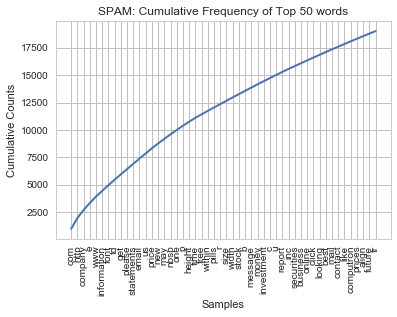

In [80]:
fdistspam.plot(50, cumulative = True, title = "SPAM: Cumulative Frequency of Top 50 words")

### Top 50 words by frequency - HAM

In [81]:
fdistham = FreqDist(clean1(getTokens(hamDocs))) # frequency distribution
print([item for item in fdistham.most_common(50)])

[('ect', 13897), ('hou', 7281), ('enron', 6555), ('gas', 2861), ('deal', 2789), ('com', 2717), ('please', 2715), ('meter', 2459), ('cc', 2359), ('pm', 2325), ('hpl', 2318), ('daren', 1901), ('thanks', 1813), ('corp', 1710), ('know', 1438), ('mmbtu', 1349), ('e', 1338), ('j', 1300), ('forwarded', 1296), ('need', 1257), ('farmer', 1137), ('let', 1086), ('attached', 1083), ('xls', 1020), ('see', 1018), ('new', 1003), ('may', 960), ('l', 923), ('contract', 883), ('volume', 877), ('would', 875), ('robert', 875), ('day', 874), ('sitara', 861), ('nom', 831), ('texas', 796), ('get', 790), ('volumes', 790), ('month', 780), ('questions', 760), ('pec', 752), ('deals', 745), ('price', 735), ('ena', 732), ('bob', 706), ('th', 706), ('flow', 673), ('message', 669), ('energy', 664), ('file', 652)]


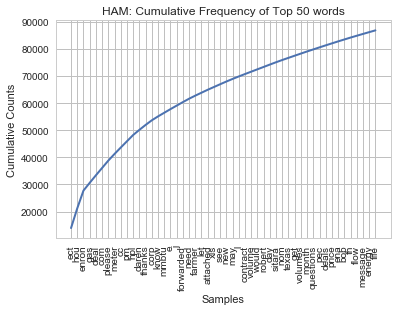

In [82]:
fdistham.plot(50, cumulative = True, title = "HAM: Cumulative Frequency of Top 50 words")

*Upon examination of the unigram frequency distributions for both SPAM and HAM, it is clear that the top 50 words for HAM make up a greater proportion of its total words relative to SPAM. This was expected as SPAM exhibited to have a more extensive vocabulary in previous corpus statistics.*

*Distinguishing features observed for SPAM includes words like ('http', 'www'). The top 50 frequency lexicon for SPAM appears quite distinct from HAM.*

### Measure the Overlap of High Frequency Words Between SPAM and HAM

In [83]:
print("Top N Proportion of Word Overlap:\n")
top_n_list = [50, 100, 500, 1000, 2000, 3000]
for n in top_n_list:
    print(n, len(set([t[0] for t in fdistham.most_common(n)]) & set([t[0] for t in fdistspam.most_common(n)])) / n)    

Top N Proportion of Word Overlap:

50 0.16
100 0.26
500 0.374
1000 0.396
2000 0.426
3000 0.4493333333333333


### Sample of Common Words between SPAM and HAM

In [94]:
n = 100
high_freq_common = list(set([t[0] for t in fdistham.most_common(n)]) & set([t[0] for t in fdistspam.most_common(n)]))
print("There are {:d} highly frequent words that are common to both SPAM and HAM:\n".format(len(high_freq_common)))
print(high_freq_common)

There are 26 highly frequent words that are common to both SPAM and HAM:

['message', 'x', 'please', 'mail', 'could', 'like', 'us', 'gas', 'price', 'may', 'time', 'get', 'see', 'net', 'need', 'would', 'l', 'information', 'th', 'company', 'p', 'new', 'e', 'one', 'also', 'com']


### Sample of Least Common Words in SPAM and HAM

In [86]:
print("Sample of the least common words in SPAM:\n")
print(fdistspam.hapaxes()[:50])
print("There are {:d} hapaxes in the text".format(len(fdistspam.hapaxes())))

Sample of the least common words in SPAM:

['dobmeos', 'stukm', 'plentiful', 'deficient', 'diminished', 'quickens', 'disappearance', 'thickness', 'texture', 'alertness', 'resistance', 'illness', 'strengthened', 'swings', 'oxwq', 'ogrg', 'lqlokeolnq', 'lnu', 'nowthe', 'involves', 'monies', 'consummating', 'tactically', 'favourably', 'favorably', 'disposed', 'obligationin', 'technicalities', 'explicitly', 'conceived', 'purposefully', 'arousing', 'forestall', 'personality', 'inks', 'famed', 'baldacci', 'simulutors', 'renews', 'motorsports', 'extension', 'opry', 'mills', 'superspeedway', 'chapin', 'venues', 'simulator', 'racers', 'nadeau', 'thumbs']
There are 21258 hapaxes in the text


In [87]:
print("Sample of the least common words in HAM:\n")
print(fdistham.hapaxes()[:50])
print("There are {:d} hapaxes in the text".format(len(fdistham.hapaxes())))

Sample of the least common words in HAM:

['erroneously', 'advises', 'mscf', 'ftp', 'strangas', 'rohan', 'dunns', 'transalta', 'rennie', 'accomodates', 'divert', 'omission', 'gpm', 'sliding', 'bryson', 'jeter', 'picks', 'tgt', 'limiting', 'dbas', 'mod', 'sched', 'personell', 'overs', 'unders', 'chryal', 'discrecpancy', 'hortense', 'drushell', 'anthing', 'lehrer', 'maxey', 'ocurring', 'hhere', 'sourced', 'remembers', 'indices', 'lichentwalter', 'spekels', 'moseman', 'markey', 'mosey', 'svehla', 'surprised', 'britten', 'avail', 'rarely', 'shippling', 'hymel', 'mcfaddin']
There are 6591 hapaxes in the text


Observations:
* *The top 50 - 100 words for SPAM and HAM seem to be mutually exclusive for the most part. However, just the top 50-100 words may be insufficient in classifying SPAM emails due to its large vocabulary, and unigram features for classification will likely need to be substantially extended*
* *There are 26 highly frequent words that are common to both SPAM and HAM. For the purposes of this analysis, it might be beneficial to remove these words by adding them to the Stopwords list.*
* *SPAM emails contain almost four times as many hapaxes (very uncommon words) compared to HAM emails. For the purposes of this analysis, it might be beneficial to remove the hapaxes by adding them to the Stopwords list.*

Actions:
* *Define and add to Stopwords list: 'message', 'x', 'please', 'mail', 'could', 'like', 'us', 'gas', 'price', 'may', 'time', 'get', 'see', 'net', 'need', 'would', 'l', 'information', 'th', 'company', 'p', 'new', 'e', 'one', 'also', 'com'*
* *These are high frequency words that are common to both SPAM and HAM; therefore these words will be added to Stopwords.*

In [99]:
# re-define stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
addtlstopwords = ['subject'] + high_freq_common + fdistspam.hapaxes() + fdistham.hapaxes()
stopwords = stopwords + addtlstopwords
print("There are a total of {:d} stopwords defined".format(len(stopwords)))

There are a total of 28055 stopwords defined


In [122]:
# function to print top n bigram frequency distribution
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# param type: 'freq' (frequency) or 'mi' (mutual information)
# param n: top n parameter for bigrams to print
# prints results
# returns scored bigrams
def getBigramDist(documents, n, type = 'freq'):
    tokens = [w.lower() for w in getTokens(documents)]
    measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens) # scorer
    finder.apply_word_filter(alpha_filter) # exclude non-alphabetic words
    finder.apply_word_filter(lambda w: w in stopwords) # exclude stop words
    if type == 'mi':
        finder.apply_freq_filter(5) # frequency filter of greater than or equal to 5
        scored = finder.score_ngrams(measures.pmi) # distribution of mutual information
        print("Top 100 most common strongly connected bigrams out of total {:d} unique bigrams:\n".format(len(scored)))
    else:
        # distribution of frequency as proportion of the bigram count to count of all bigrams
        scored = finder.score_ngrams(measures.raw_freq)
        print("Top 100 most common bigrams out of total {:d} unique bigrams:\n".format(len(scored)))
    print([score[0] for score in scored[:n]])
    return scored

### Top 100 Bigrams by Frequency - SPAM

In [123]:
%%time
bigramSpamFreq = getBigramDist(spamDocs, n = 100, type = 'freq')

Top 100 most common bigrams out of total 30656 unique bigrams:

[('looking', 'statements'), ('td', 'td'), ('investment', 'advice'), ('tr', 'td'), ('forward', 'looking'), ('windows', 'xp'), ('duty', 'free'), ('ali', 'duty'), ('td', 'width'), ('xp', 'professional'), ('tr', 'tr'), ('soft', 'tabs'), ('jpg', 'width'), ('securities', 'act'), ('best', 'regards'), ('without', 'notice'), ('adobe', 'photoshop'), ('money', 'back'), ('third', 'party'), ('united', 'states'), ('jebel', 'ali'), ('microsoft', 'office'), ('office', 'xp'), ('gif', 'width'), ('font', 'color'), ('statements', 'within'), ('font', 'face'), ('ooking', 'statements'), ('special', 'offers'), ('email', 'address'), ('past', 'performance'), ('text', 'format'), ('material', 'within'), ('microsoft', 'windows'), ('exchange', 'act'), ('format', 'reply'), ('free', 'zone'), ('iii', 'passed'), ('plain', 'text'), ('remove', 'instructions'), ('sales', 'department'), ('somehow', 'gotten'), ('title', 'iii'), ('apc', 'cisco'), ('canada', 'u')

### Top 100 Bigrams by Frequency - HAM

In [127]:
%%time 
bigramHamFreq = getBigramDist(hamDocs, n = 100, type = 'freq')

Top 100 most common bigrams out of total 24957 unique bigrams:

[('ect', 'cc'), ('daren', 'j'), ('j', 'farmer'), ('attached', 'file'), ('teco', 'tap'), ('enron', 'cc'), ('north', 'america'), ('tenaska', 'iv'), ('enron', 'north'), ('robert', 'cotten'), ('pat', 'clynes'), ('ami', 'chokshi'), ('america', 'corp'), ('melissa', 'graves'), ('aimee', 'lannou'), ('hpl', 'actuals'), ('deal', 'ticket'), ('george', 'weissman'), ('b', 'camp'), ('howard', 'b'), ('hpl', 'iferc'), ('ls', 'hpl'), ('rita', 'wynne'), ('cotton', 'valley'), ('hsc', 'less'), ('anita', 'luong'), ('melissa', 'jones'), ('hpl', 'lsk'), ('lsk', 'ic'), ('actual', 'flow'), ('daren', 'farmer'), ('make', 'sure'), ('charlie', 'stone'), ('calpine', 'daily'), ('f', 'herod'), ('megan', 'parker'), ('sherlyn', 'schumack'), ('hpl', 'meter'), ('next', 'week'), ('mary', 'poorman'), ('counterparty', 'meter'), ('duke', 'energy'), ('gary', 'w'), ('w', 'lamphier'), ('demand', 'fee'), ('clem', 'cernosek'), ('lone', 'star'), ('volume', 'management

### Top 100 Bigrams by Mutual Information - SPAM

In [128]:
%%time 
bigramSpamMI = getBigramDist(spamDocs, n = 100, type = 'mi')

Top 100 most common strongly connected bigrams out of total 1394 unique bigrams:

[('pompeu', 'fabra'), ('universitat', 'pompeu'), ('yasser', 'arafat'), ('aftermath', 'showed'), ('bingoline', 'lotteria'), ('encarta', 'encyclopedia'), ('encyclopedia', 'delux'), ('lightly', 'injured'), ('representaciones', 'gorbea'), ('bupropion', 'hcl'), ('butalbital', 'apap'), ('lling', 'lisst'), ('remained', 'beneath'), ('spokesman', 'raanan'), ('severely', 'wounded'), ('ects', 'tras'), ('ppin', 'hin'), ('cllick', 'heree'), ('pfizer', 'viiagrra'), ('tim', 'ger'), ('appr', 'oval'), ('burns', 'calorized'), ('leaden', 'madras'), ('madras', 'meson'), ('meson', 'mitosis'), ('mitosis', 'quadrant'), ('pamphlet', 'distributed'), ('relaxation', 'leaden'), ('settlements', 'nearby'), ('spe', 'ume'), ('tri', 'cyclen'), ('italian', 'crafted'), ('soldier', 'remained'), ('congratulatory', 'salaam'), ('fatah', 'hawks'), ('firing', 'mortar'), ('kno', 'nds'), ('palestinians', 'firing'), ('par', 'mois'), ('quadrant', 'c

### Top 100 Bigrams by Mutual Information - HAM

In [129]:
%%time 
bigramHamMI = getBigramDist(hamDocs, n = 100, type = 'mi')

Top 100 most common strongly connected bigrams out of total 2182 unique bigrams:

[('dobbin', 'huffsmith'), ('kimat', 'singla'), ('kori', 'loibl'), ('inja', 'chun'), ('los', 'angeles'), ('rare', 'instances'), ('chyral', 'hankins'), ('cecilia', 'olvera'), ('janie', 'aguayo'), ('maritta', 'mullet'), ('triple', 'lutz'), ('faith', 'killen'), ('brant', 'reves'), ('hyatt', 'regency'), ('torrey', 'moorer'), ('huge', 'favor'), ('deboisblanc', 'denny'), ('lamay', 'gaslift'), ('alfonso', 'trabulsi'), ('larrissa', 'sharma'), ('wilma', 'easter'), ('dutch', 'quigley'), ('gasper', 'rice'), ('chantelle', 'villanueva'), ('imelda', 'frayre'), ('spec', 'prov'), ('karie', 'hastings'), ('lal', 'echterhoff'), ('hoff', 'heller'), ('hisd', 'schools'), ('samuel', 'schott'), ('carrie', 'hollomon'), ('nancy', 'stivers'), ('dba', 'garrison'), ('hunaid', 'engineer'), ('las', 'vegas'), ('russell', 'diamond'), ('moody', 'gardens'), ('trust', 'signer'), ('dana', 'daigle'), ('knox', 'westmoreland'), ('altra', 'gms'),

Observations:
* *Bigrams for SPAM exhibited more references to retail product entities, references to selling, and non-English phrases.*
* *Bigrams for HAM exhibited more references to organization, person, and location entities.*
* *Interestingly, bigrams scored by mutual information were more prevalent for HAM than for SPAM. These are referred to as strongly connected word pairs, rather than the most frequent word pairs. This makes sense because those for HAM made greater reference especially to persons, as well as business jargon.*

Actions:
* *Complete lists of bigrams were extracted for modeling and feature engineering.*


## Modeling
Lorum ipsum....

# Results

Lorum ipsum....

# Conclusion

Lorum ipsum....